# Assignment 9: PyTorch

List your team members (name and immatriculation number) and indicate whether you are a B.Sc. Data Science or other group in the following cell:


  - Kuang-Yu Li, st169971@stud.uni-stuttgart.de, 3440829
  - Ya-Jen Hsu, st169013@stud.uni-stuttgart.de, 3449448
  - Gabriella Ilena, st169935@stud.uni-stuttgart.de, 3440942

**If you wish to present any of the tasks, please tell us here.**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import skimage  # Package name: scikit-image, requires installation of package 'Pillow'
import skimage.io
import torch  # Package name: torch (for pip), pytorch (for conda)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

In [2]:
def load_airfoil_dataset():
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    
    data = np.genfromtxt('airfoil_self_noise.csv')
    X, y = data[:, :5], data[:, 5]
    y = y.reshape(-1, 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2020)

    scaler_X = StandardScaler().fit(X_train)
    scaler_y = StandardScaler().fit(y_train)
    X_train = scaler_X.transform(X_train)
    X_test = scaler_X.transform(X_test)
    y_train = scaler_y.transform(y_train)
    y_test = scaler_y.transform(y_test)
    
    return X_train, X_test, y_train, y_test


def load_traffic_sign_dataset():
    import os
    
    def load_data(directory):
        directories = [d for d in os.listdir(directory)
                       if os.path.isdir(os.path.join(directory, d))]
        labels = []
        images = []
        for d in directories:
            label_directory = os.path.join(directory, d)
            file_names = [os.path.join(label_directory, f)
                          for f in os.listdir(label_directory)
                          if f.endswith(".ppm")]
            for f in file_names:
                images.append(skimage.io.imread(f))
                labels.append(int(d))
        return np.array(images), np.array(labels)
            
    X_train, y_train = load_data('BelgiumTSC_Training/Training')
    X_test, y_test = load_data('BelgiumTSC_Testing/Testing')
    
    return X_train, X_test, y_train, y_test


In [3]:
class BasicDataset(data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __getitem__(self, idx):
        return dict(X=self.X[idx], y=self.y[idx])
    
    def __len__(self):
        return self.X.shape[0]

    
class FlattenedImageDataset(data.Dataset):
    def __init__(self, X, y):
        self.X = np.array([img.flatten() for img in X])
        self.y = y
        
    def __getitem__(self, idx):
        return dict(X=self.X[idx], y=self.y[idx])
    
    def __len__(self):
        return self.X.shape[0]


## Task 1: Linear Regression with SGD in PyTorch

In this first task, you will implement a linear regression model in PyTorch without using the existing [`torch.nn.Linear`](https://pytorch.org/docs/master/generated/torch.nn.Linear.html) module. Instead use basic math operations such as addition and matrix multiplication for the computation of the forward pass. The computation of gradients and performing backpropagation will be automatically handled by PyTorch.

Initialize the weights and bias of the linear model using the standard Gaussian distribution similar to Assignment 8 - Task 3. The `bias` parameter selects whether a bias term should be included in the model.

*Hint:* To allow training of the network, the weights of the model have to be made trainable. A convenient way to do this is to instantiate the learnable parameters as [`torch.nn.Parameter`](https://pytorch.org/docs/master/generated/torch.nn.parameter.Parameter.html) objects and set them as fields of a [`torch.nn.Module`](https://pytorch.org/docs/master/generated/torch.nn.Module.html) subclass.

In [4]:
class MyLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.bias = bias
        
        # Your initialization code comes here.
        # Initialize weights and biases for a network of one hidden layer with 10 neurons
        self.w0 = nn.Parameter(torch.randn(in_features, 10))
        self.w1 = nn.Parameter(torch.randn(10, out_features))
        self.b0 = nn.Parameter(torch.randn(10))
        self.b1 = nn.Parameter(torch.randn(out_features))
    
    def forward(self, X):
        # The forward pass of the linear regression comes here.
        if self.bias:
          output0 = F.relu(torch.matmul(X, self.w0) + self.b0)
          output1 = torch.matmul(output0, self.w1) + self.b1
        else:
          output0 = F.relu(torch.matmul(X, self.w0))
          output1 = torch.matmul(output0, self.w1)
        return output1


We provide you with the necessary code to train and compare your model and the reference implementation of PyTorch. You will have to replicate similar training code for multi-class classification in Task 2.

In [5]:
from sklearn.linear_model import LinearRegression

# Define hyperparameters
batch_size = 64
learning_rate = 0.01
epochs = 25
in_features = 5
out_features = 1

# Initialize models.
my_linear = MyLinear(in_features, out_features)
pt_linear = nn.Linear(in_features, out_features)

# Load dataset.
X_train, X_test, y_train, y_test = load_airfoil_dataset()
dataset_train = BasicDataset(X_train, y_train)


def train_model(model, dataset, learning_rate, batch_size, epochs): 
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Train linear model using SGD on mini-batches.
    for epoch in range(epochs):
        # DataLoader generates random batches from a given dataset.
        data_loader = data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True)
         # We want to report the training loss after each epoch
        epoch_loss = 0.0 

        for batch in data_loader:
            # After each iteration of the training step, reset the local gradients stored in the network to zero.
            model.zero_grad()
            model.zero_grad()

            # Compute the forward pass.
            # Numpy uses doubles by default but Torch expects floats, since the added accuracy of doubles 
            # is generally not useful for neural networks.
            # We fix this issue by changing the datatype of 'X' and 'y' with the .float method.
            yhat = model.forward(batch['X'].float())

            # Compute the batch error.
            batch_loss = F.mse_loss(yhat, batch['y'].float())
            epoch_loss += batch_loss.item()
            
            # Backpropagate the gradient and adjust the weights.
            batch_loss.backward()
            optimizer.step()
        
        print(f'Epoch {epoch+1}/{epochs} - Loss: {epoch_loss}')

        
def evaluate_model(model, X_test, y_test):
    X_test = torch.from_numpy(X_test).float()    
    yhat = model.forward(X_test).detach().numpy()
    mse = np.mean(np.power(yhat - y_test, 2))
    print('Test MSE:', mse)
    
    
print('MyLinear')
train_model(my_linear, dataset_train, learning_rate, batch_size, epochs)
evaluate_model(my_linear, X_test, y_test)
print()
print('torch.nn.Linear')
train_model(pt_linear, dataset_train, learning_rate, batch_size, epochs)
evaluate_model(pt_linear, X_test, y_test)
print()
print('sklearn.linear_model.LinearRegression')
print('Test MSE:', np.mean(np.power(LinearRegression().fit(X_train, y_train).predict(X_test) - y_test, 2)))

MyLinear
Epoch 1/25 - Loss: 58.718929290771484
Epoch 2/25 - Loss: 26.633734345436096
Epoch 3/25 - Loss: 20.010624289512634
Epoch 4/25 - Loss: 16.997471928596497
Epoch 5/25 - Loss: 14.84110027551651
Epoch 6/25 - Loss: 13.944650053977966
Epoch 7/25 - Loss: 12.778719663619995
Epoch 8/25 - Loss: 12.200604557991028
Epoch 9/25 - Loss: 11.665629863739014
Epoch 10/25 - Loss: 11.047426491975784
Epoch 11/25 - Loss: 10.875730484724045
Epoch 12/25 - Loss: 10.443496346473694
Epoch 13/25 - Loss: 10.100652933120728
Epoch 14/25 - Loss: 9.782801240682602
Epoch 15/25 - Loss: 9.362159758806229
Epoch 16/25 - Loss: 9.326132208108902
Epoch 17/25 - Loss: 9.24456125497818
Epoch 18/25 - Loss: 8.947509914636612
Epoch 19/25 - Loss: 8.97649297118187
Epoch 20/25 - Loss: 8.664998143911362
Epoch 21/25 - Loss: 8.622910141944885
Epoch 22/25 - Loss: 8.516578495502472
Epoch 23/25 - Loss: 8.381696999073029
Epoch 24/25 - Loss: 8.295689553022385
Epoch 25/25 - Loss: 8.256267666816711
Test MSE: 0.5047083488234987

torch.nn.L

## Task 2: Image Classification with FNN

In this task, you will implement an FNN for multi-class classification of traffic signs.

Download the [training](https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Training.zip) and [test](https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Testing.zip) data. Unpack the zip-files in the same directory as the Jupyter notebook.

The shape of each image is `(width=128, height=128, channels=3)`. The channels represent the color of each pixel.
FNN cannot directly operate on images. We therefore have to flatten each image to a vector.
We achieve this with the [`numpy.flatten`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.flatten.html) method. The class `FlattenedImageDataset` may be used for training of your FNN.

Implement a feedforward neural network with multiple layers using either [`nn.Sequential`](https://pytorch.org/docs/master/generated/torch.nn.Sequential.html) class or by subclassing [`nn.Module`](https://pytorch.org/docs/master/generated/torch.nn.Module.html) as shown in Task 1.  Use a combination [`nn.Linear`](https://pytorch.org/docs/master/generated/torch.nn.Linear.html) and activation functions (e.g. [`nn.ReLU`](https://pytorch.org/docs/master/generated/torch.nn.ReLU.html)) to implement the fully connected layers of an FNN. Experiment with different activation functions (ReLU, tanh, ...), different depths, and widths. Use the Adam optimizer ([`optim.Adam`](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam)) for optimization.

You should evaluate your model by at least computing the relevant metrics (e.g. F1-score) and looking at a few misclassified samples.

*Note:* You may modify the code from Task 1. However, you need to use an appropriate loss function and output layer for your FNN to train your network for multi-class classification. Use your knowledge from the lecture to identify the correct methods in the [PyTorch documentation](https://pytorch.org/docs/stable/index.html).

In [6]:
from skimage.transform import resize
# Load training and testing data.
X_train, X_test, y_train, y_test = load_traffic_sign_dataset()
print('Training samples:', X_train.shape[0])
print('Testing samples:', X_test.shape[0])
print('Image shape:', X_train[0].shape)
print('Test image shape:', X_test[0].shape)
print('#Classes:', len(np.unique(y_train)))

# Pre-processing: resize all sample images to be of shape 128 * 128 *3
X_train_resized = list()
X_test_resized = list()

for x_tr in X_train:
  x = resize(x_tr, (128, 128))
  X_train_resized.append(x)
X_train_resized = np.asarray(X_train_resized, dtype=np.float32)

for x_ts in X_test:
  x = resize(x_ts, (128, 128))
  X_test_resized.append(x)
X_test_resized = np.asarray(X_test_resized, dtype=np.float32)

print('New image shape:', X_train_resized[0].shape, X_test_resized[0].shape)
print('Data type:', type(X_train_resized))

Training samples: 4575
Testing samples: 2520
Image shape: (159, 159, 3)
Test image shape: (109, 108, 3)
#Classes: 62
New image shape: (128, 128, 3) (128, 128, 3)
Data type: <class 'numpy.ndarray'>


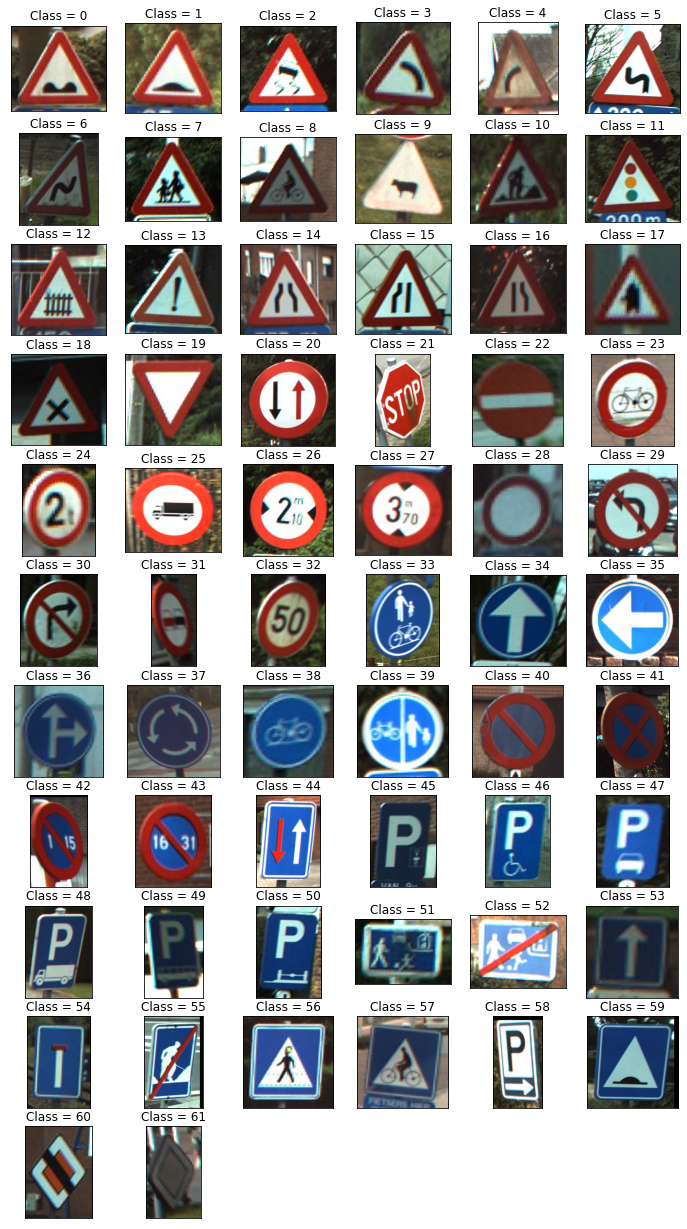

In [7]:
# Show sample for each class.
class_labels = set(np.unique(y_train))
n_classes = len(class_labels)

n_cols = 6
n_rows = n_classes // n_cols + 1
fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*2, n_rows*2))
for label in sorted(class_labels):
    row = label // n_cols
    col = label % n_cols
    img_idx = np.argmax(y_train == label)
    ax[row, col].imshow(X_train[img_idx])
    ax[row, col].set_xticks([])
    ax[row, col].set_yticks([])
    ax[row, col].set_title(f'Class = {label}')
    
leftover_subplots = n_cols - (max(class_labels) % n_cols) - 1
for i in range(leftover_subplots):
    fig.delaxes(ax[-1, -(i+1)])

In [8]:
# Implement your model and training here.

# Define hyperparameters
batch_size = 64
learning_rate = 0.001
epochs = 15
in_features = 128 * 128 * 3
out_features = 62

# Flatten image
flattened_train = FlattenedImageDataset(X_train_resized, y_train)

# Define a network with two dense hidden layers with 256 and 128 neurons each
model = nn.Sequential(
          nn.Linear(128*128*3, 256),
          nn.LeakyReLU(),
          nn.Linear(256, 128),
          nn.LeakyReLU(),
          nn.Linear(128, 62),
          nn.LogSoftmax(dim=1)
          )

def train_model(model, dataset, learning_rate, batch_size, epochs): 
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_func = nn.NLLLoss()

    # Train linear model using SGD on mini-batches.
    for epoch in range(epochs):
        # DataLoader generates random batches from a given dataset.
        data_loader = data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True)

        epoch_loss = 0.0 

        for batch in data_loader:
            # After each iteration of the training step, reset the local gradients stored in the network to zero.
            model.zero_grad()
            model.zero_grad()

            # Prediction
            yhat = model(batch['X'].float())

            # Compute the batch error.
            batch_loss = loss_func(yhat, batch['y'].long())
            epoch_loss += batch_loss.item()
            
            # Backpropagate the gradient and adjust the weights.
            batch_loss.backward()
            optimizer.step()
        
        print(f'Epoch {epoch+1}/{epochs} - Loss: {epoch_loss}')

# Training
print("Start training:")
train_model(model, dataset=flattened_train, learning_rate=learning_rate, batch_size=batch_size, epochs=epochs)

Start training:
Epoch 1/15 - Loss: 210.95652866363525
Epoch 2/15 - Loss: 86.83482420444489
Epoch 3/15 - Loss: 51.96857833862305
Epoch 4/15 - Loss: 42.298376590013504
Epoch 5/15 - Loss: 32.91840386390686
Epoch 6/15 - Loss: 23.109772883355618
Epoch 7/15 - Loss: 21.699440993368626
Epoch 8/15 - Loss: 13.680432002991438
Epoch 9/15 - Loss: 14.65744113177061
Epoch 10/15 - Loss: 11.18602504581213
Epoch 11/15 - Loss: 9.19142434000969
Epoch 12/15 - Loss: 12.176076918840408
Epoch 13/15 - Loss: 6.520364318974316
Epoch 14/15 - Loss: 10.018464421853423
Epoch 15/15 - Loss: 13.382627222687006


In [12]:
# Implement your evaluation here.
import sklearn.metrics as skmetric

def evaluate_model(model, X_test):
    X_test = torch.from_numpy(X_test).float()    
    yhat = model(X_test).detach().numpy()
    yhat = np.argmax(yhat, axis=1) # Finding the predicted class
    return yhat

# Flatten and reshape the test data
X_test_resized = X_test_resized.flatten().reshape(X_test_resized.shape[0], 128*128*3)

# Get predictions
y_pred = evaluate_model(model, X_test_resized)

# Test scores
print("Test report:")
print("Accuracy:", skmetric.accuracy_score(y_test, y_pred))
print("F1 score:", skmetric.f1_score(y_test, y_pred, average='weighted'))

Test report:
Accuracy: 0.8146825396825397
F1 score: 0.8111801731813039


## Task 3: Image Classification with CNN

*For all students other than B.Sc. Data Science.*

In this task, you will implement a convolutional neural network (CNN) for classification of traffic signs.
Your model should use [`nn.Conv2d`](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d) layers to compute convolutions, any kind of pooling (e.g. [`nn.MaxPool2d`](https://pytorch.org/docs/stable/nn.html#torch.nn.MaxPool2d)), and a dense output network.
For inspiration look at the architecture of AlexNet (presented in the lecture).
For simplicity, you may use the `nn.Sequential` class.

You should evaluate your model by at least computing the relevant metrics (e.g. F1-score) and looking at a few misclassified samples.

*Note:* For the most part, you can reuse your code from Task 2. However, you have to use images in their original format `(128, 128, 3)` instead of the flattened shape.

In [ ]:
# Implement your model and training here.

In [ ]:
# Implement your evaluation here.